In [1]:
# https://people.brandeis.edu/~blebaron/classes/fin250a/regression/armax.html
# http://r-statistics.co/Time-Series-Analysis-With-R.html
library(forecast)
library(tidyverse) # tidy data

library(tseries)
library(MTS)

library(tsDyn)

library(vars) # post-estimation procedures to ensure adequacy of model
library(urca)
library(mFilter)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich


Attaching package: ‘strucchange’


The following object is masked from ‘package:stringr’:

    boundary


Loading required package: urca

Loading required package: lm

# Impulse Response Analysis
to describe the evolution of a model's variables in reaction to a shock by tracing the transmission of a single shock within a noisy system.

In [2]:
# generate a random number between 1 and 817
sample(0:1191, 1) #400

[1] 79

In [3]:
# data prep
ts_data <- read_csv('employment_covid_mobility_ts_diff.csv')
# drop X column
drops <- c("X")
ts_data <- ts_data[ , !(names(ts_data) %in% drops)]
# pivot data
pivot_emp <- ts_data %>%
    dplyr::select(date, countyfips, emp_incbelowmed) %>%
        pivot_wider(names_from = countyfips, values_from = emp_incbelowmed)
pivot_covid <- ts_data %>%
    dplyr::select(date, countyfips, new_case_rate) %>%
        pivot_wider(names_from = countyfips, values_from = new_case_rate)
pivot_mobility <- ts_data %>%
    dplyr::select(date, countyfips, gps_away_from_home) %>%
        pivot_wider(names_from = countyfips, values_from = gps_away_from_home)
# convert to timeseries
pivot_emp_ts <- data.frame(apply(pivot_emp[,2:817], 2, function(x) ts(x)), check.names=FALSE)
pivot_emp_ts$date <- pivot_emp$date
pivot_covid_ts <- data.frame(apply(pivot_covid[,2:817], 2, function(x) ts(x)), check.names=FALSE)
pivot_covid_ts$date <- pivot_covid$date
pivot_mobility_ts <- data.frame(apply(pivot_mobility[,2:817], 2, function(x) ts(x)), check.names=FALSE)
pivot_mobility_ts$date <- pivot_mobility$date

New names:
* `` -> ...1

Rows: 78094 Columns: 9

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (8): ...1, countyfips, gps_away_from_home, gps_diff, emp_incbelowmed, e...
date (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [4]:
#choose random county & store selected ts to emp, covid or mobility
emp <- pivot_emp[,140]
colnames(emp)[1] <- c("emp")
covid <- pivot_covid[,140]
colnames(covid)[1] <- c("covid")
mobility <- pivot_mobility[,140]
colnames(mobility)[1] <- c("mobility")

## bind to one object

In [9]:
dset <- cbind(emp, covid, mobility)

## Build VAR

In [10]:
model <- VAR(dset, p = 22, type="const")

# Impulse Response
used to obtain forecast error impulse responses, i.e. how a variable would behave at n timesteps in the event of a shock to the system.

In [30]:
# calculates the estimated response of consumption to a forecast error
ir <- irf(model, n.ahead = 65, impulse = "covid", response = "emp", ortho = FALSE, runs = 1000)

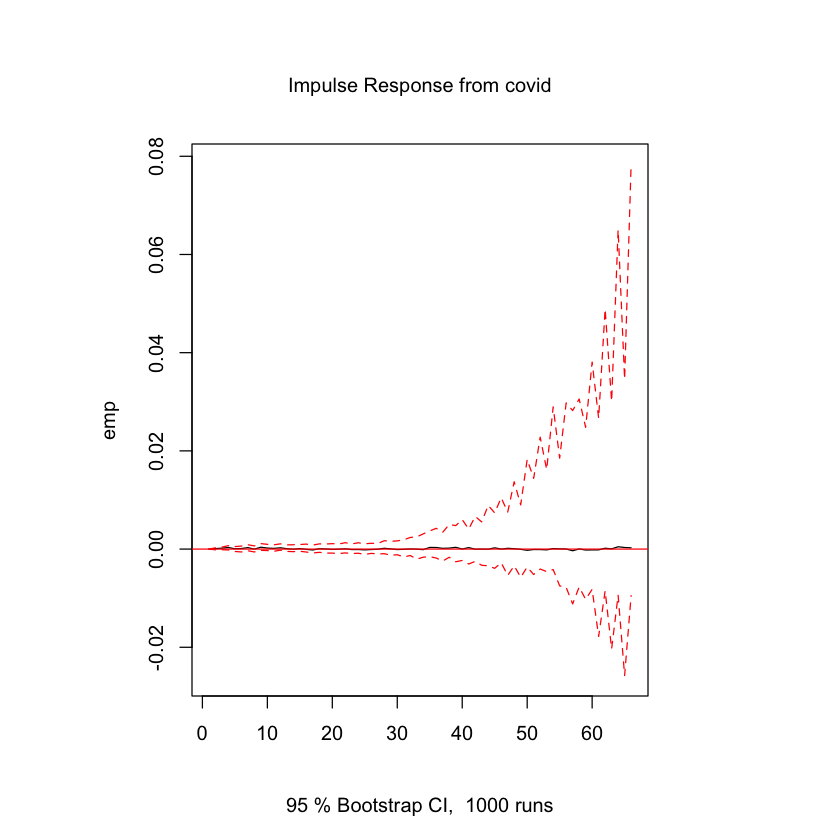

In [31]:
plot(ir) 
# positive shock to covid will negatively affect EMP 
# at lags (days) 14, 17, 19, 23-25
# This is consistent with our other findings!

# Note, the confidence intervals indicate that covid may have no affect, 
# or may have an entirely negative effect

Note, this cannot be used to evaluate contemporaneous relationships. This information can be found in the off-diagonal elements of the symmetric variance-covariance matrix. When these elements are not zero, we can assume there is contemporaneous correlation between variables found in the VAR model. 

# Orthogonal Impulese Responses
To identify the shocks of a VAR model, use the orthogonal impulse responses. Decompose the variance-covariance matrix via the Choleski decomposition. Given the estimated variance, covariance matrix P, the decomposition can be calculated using:

In [32]:
# calculates the estimated response of consumption to a forecast error
ir.ortho <- irf(model, n.ahead = 65, impulse = "covid", response = "emp", ortho = TRUE, runs = 1000)

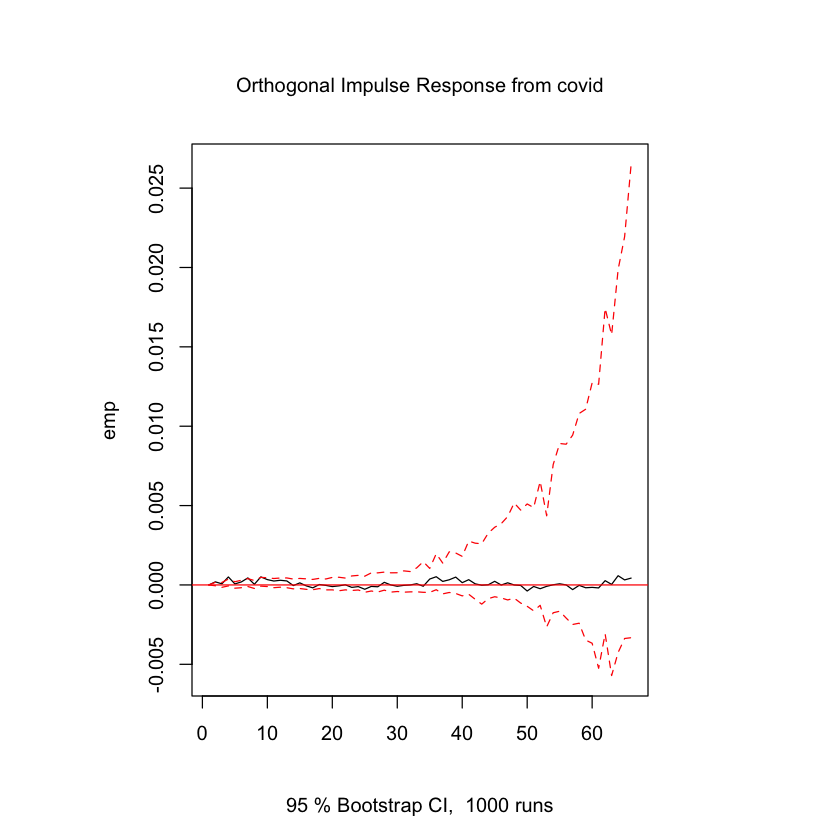

In [33]:
plot(ir.ortho)

## Variance Decomposition
How much are these variables influenced by shocks?

In [28]:
FEVD1 <- fevd(model, n.ahead = 65)

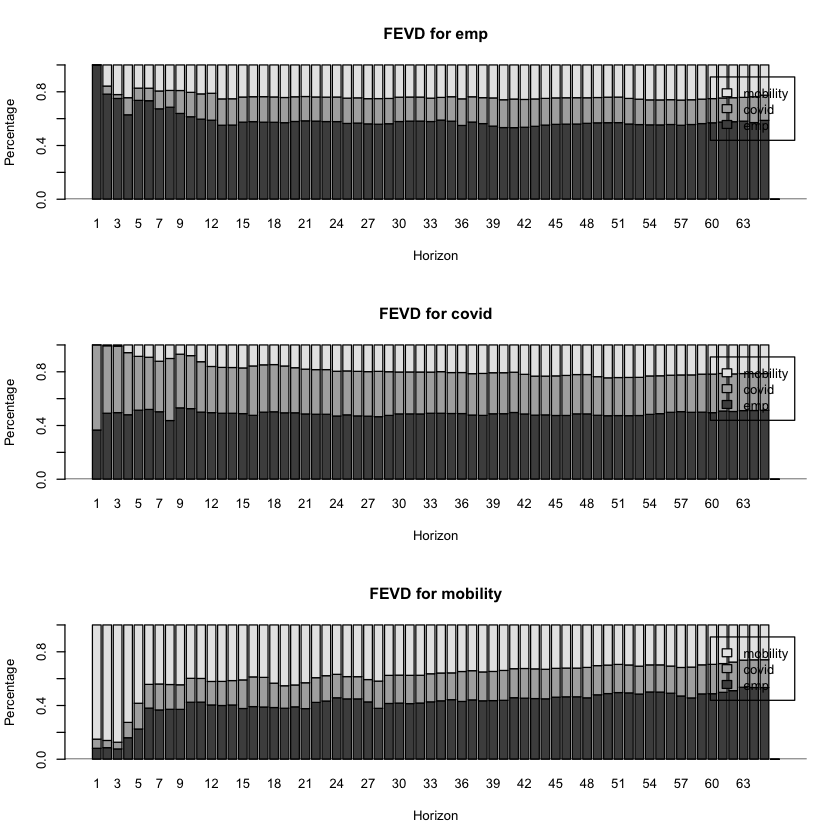

In [29]:
plot(FEVD1)

covid seems to be very influenced by emp.
emp is minimally influenced at first, but covid and mobility become more of a factor at around lag 14.

# Cholesky Decomposition
decompose the variance-covariance matrix

In [34]:
model_summary <- summary(model)

In [35]:
t(chol(model_summary$covres))
# shock to covid has a contemporaneous effect on mobility

,emp,covid,mobility
emp,0.0005559875,0.0000000000,0.000000000
covid,-0.8550212534,1.1241875760,0.000000000
mobility,0.0007672830,0.0007019998,0.002479399


In [ ]:
# arch effects would indicate clustered volatility in the model

In [ ]:
# Sources
https://www.economics.utoronto.ca/jfloyd/papers/varnote.pdf
https://www.r-econometrics.com/timeseries/irf/